# Live Camera Preview in Notebook
## For Remote Access - No External Windows Needed

## 1. Setup

In [1]:
import numpy as np
import cv2
from picamera2 import Picamera2
import time
from IPython.display import display, Image, clear_output
import ipywidgets as widgets

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Initialize Camera

In [2]:
# Initialize camera
picam2 = Picamera2()
config = picam2.create_preview_configuration(
    main={"format": "RGB888", "size": (1280, 720)}
)
picam2.configure(config)
picam2.start()
time.sleep(0.5)

print("Camera initialized!")
print(f"Resolution: {config['main']['size']}")

[1:12:42.868074850] [7225]  INFO Camera camera_manager.cpp:330 libcamera v0.5.2+99-bfd68f78
[1:12:42.876443874] [7240]  INFO RPI pisp.cpp:720 libpisp version 1.3.0
[1:12:42.879337773] [7240]  INFO IPAProxy ipa_proxy.cpp:180 Using tuning file /usr/share/libcamera/ipa/rpi/pisp/imx477.json
[1:12:42.886151117] [7240]  INFO Camera camera_manager.cpp:220 Adding camera '/base/axi/pcie@1000120000/rp1/i2c@88000/imx477@1a' for pipeline handler rpi/pisp
[1:12:42.886164785] [7240]  INFO RPI pisp.cpp:1179 Registered camera /base/axi/pcie@1000120000/rp1/i2c@88000/imx477@1a to CFE device /dev/media2 and ISP device /dev/media1 using PiSP variant BCM2712_C0
[1:12:42.889699383] [7225]  INFO Camera camera.cpp:1215 configuring streams: (0) 1280x720-RGB888/sRGB (1) 2028x1080-BGGR_PISP_COMP1/RAW
[1:12:42.889799428] [7240]  INFO RPI pisp.cpp:1483 Sensor: /base/axi/pcie@1000120000/rp1/i2c@88000/imx477@1a - Selected sensor format: 2028x1080-SBGGR12_1X12/RAW - Selected CFE format: 2028x1080-PC1B/RAW


Camera initialized!
Resolution: (1280, 720)


## 3. Configure Detection Parameters

In [3]:
# Green tape HSV thresholds (adjust these for your setup)
lower_green = np.array([35, 50, 50])
upper_green = np.array([85, 255, 255])

# Checkerboard size (4x7 interior corners for 5x8 board)
checkerboard_size = (4, 7)

# Minimum contour area for green detection
min_area = 100

print("Detection parameters configured")

Detection parameters configured


## 4. Live Preview in Notebook

**This displays live video directly in the notebook - perfect for remote access!**

To stop: Click the stop button (■) in the toolbar above

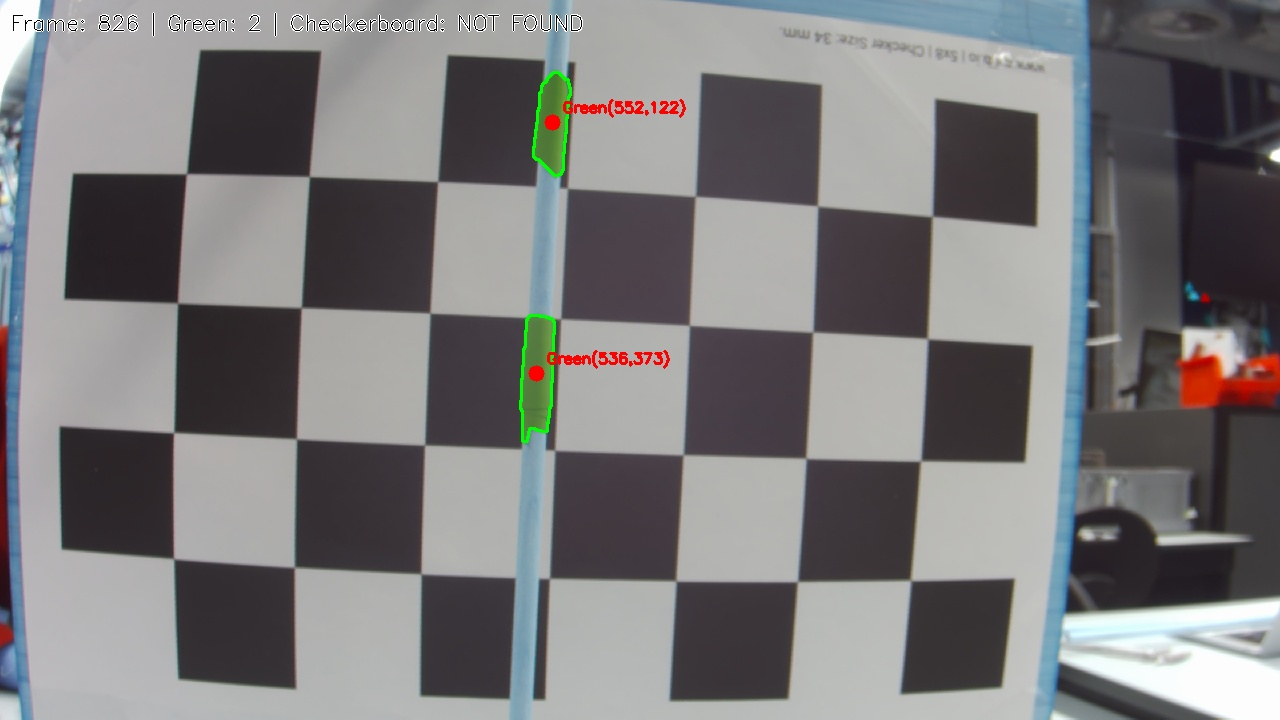


Live preview stopped by user
Total frames displayed: 827


In [5]:
print("Starting live preview... Press STOP button to interrupt")
print("")

try:
    frame_count = 0
    while True:
        # Capture frame
        frame = picam2.capture_array()
        display_frame = frame.copy()
        
        # Green detection
        hsv = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
        mask_green = cv2.inRange(hsv, lower_green, upper_green)
        
        # Clean mask
        kernel = np.ones((5, 5), np.uint8)
        mask_green = cv2.morphologyEx(mask_green, cv2.MORPH_CLOSE, kernel)
        mask_green = cv2.morphologyEx(mask_green, cv2.MORPH_OPEN, kernel)
        
        # Find green contours
        contours, _ = cv2.findContours(mask_green, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        valid_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
        
        # Draw green tape detection
        for cnt in valid_contours:
            cv2.drawContours(display_frame, [cnt], -1, (0, 255, 0), 2)
            M = cv2.moments(cnt)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                cv2.circle(display_frame, (cx, cy), 8, (255, 0, 0), -1)
                cv2.putText(display_frame, f"Green({cx},{cy})", (cx + 10, cy - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        
        # Checkerboard detection
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, checkerboard_size, None)
        if ret:
            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
            corners_refined = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            cv2.drawChessboardCorners(display_frame, checkerboard_size, corners_refined, ret)
        
        # Add info overlay
        info_text = f"Frame: {frame_count} | Green: {len(valid_contours)} | Checkerboard: {'FOUND' if ret else 'NOT FOUND'}"
        cv2.putText(display_frame, info_text, (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        cv2.putText(display_frame, info_text, (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 1)
        
        # Encode frame as JPEG
        _, buffer = cv2.imencode('.jpg', cv2.cvtColor(display_frame, cv2.COLOR_RGB2BGR))
        
        # Display in notebook
        clear_output(wait=True)
        display(Image(data=buffer.tobytes()))
        
        frame_count += 1
        time.sleep(0.033)  # ~30 FPS
        
except KeyboardInterrupt:
    print("\nLive preview stopped by user")
finally:
    print(f"Total frames displayed: {frame_count}")

## 5. Adjust HSV Thresholds (Optional)

If green detection isn't working well, adjust these values and re-run section 4:

In [ ]:
# Adjust these values based on your green tape
H_min, S_min, V_min = 35, 50, 50      # Lower bounds
H_max, S_max, V_max = 85, 255, 255    # Upper bounds

lower_green = np.array([H_min, S_min, V_min])
upper_green = np.array([H_max, S_max, V_max])

print(f"Updated HSV range:")
print(f"  Lower: {lower_green}")
print(f"  Upper: {upper_green}")

## 6. Stop Camera

In [ ]:
picam2.stop()
print("Camera stopped")

Camera stopped
